In [1]:
import os,sys
sys.path.insert(1, os.path.join(os.getcwd()  , '..'))

In [2]:
import os, glob, random
from time import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import ThresholdedReLU

from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers

import apps.config_env as cfg

from classes.image_frame import ImgFrame
from classes.video_clip import VideoClip
from models.dataset_generator import DataSetGenerator


import warnings
warnings.filterwarnings("ignore")

# from models.layer_conv import Conv2Plus1D, TConv2Plus1D
# from models.layer_encoder import Encoder5D, Decoder5D
# from models.layer_lstm import ConvLstmSeries

img_w, img_h = 64, 64 #cfg.DATA_IMG_W, cfg.DATA_IMG_H
batch_size = 2 #cfg.DATA_BATCH_SIZE
time_steps = 8 # cfg.DATA_TIME_STEP
enc_blk_count = 5  # 3 - 7
disc_blk_count = 3 # 
EPOCHS = 50

enc_filters = [64,128,256,512,512,512,512,512]
dec_filters = [512,512,512,512,256,128,64]


# dataset 설정.
data_seq_type = 'aforward'  # 'all', 'rest', 'arandom', 'aforward', 'forward', 'reverse', 'random'
data_label_type = 'same'   # 'all', 'rest', 'same', '1step'
stakced = False
overlap = False

# 전체 raw_clip 랜덤한 이미지 목록을 가져옴.
img_list = glob.glob(os.path.join(cfg.RAW_CLIP_PATH, "*.gif"))
random.shuffle(img_list)

# 이미지 목록을 train/validation용으로 9:1로 나눔.
train_val_ratio = 0.9
train_img_cnt = int(len(img_list) * train_val_ratio)
train_img_list = img_list[:train_img_cnt]
val_img_list = img_list[train_img_cnt:]

# train/validation용 generator를 생성.
tdgen = DataSetGenerator(imgs=train_img_list, batch_size=batch_size, 
                         time_step=time_steps, imgw=img_w, imgh=img_h, 
                         seq_type=data_seq_type, label_type=data_label_type,
                         stacked=stakced, overlap=overlap)

vdgen = DataSetGenerator(imgs=val_img_list, batch_size=batch_size, 
                         time_step=time_steps, imgw=img_w, imgh=img_h, 
                         seq_type=data_seq_type, label_type=data_label_type,
                         stacked=stakced, overlap=overlap)

def arry5d_to_img(arry5d, save_as='', threshold=0.0):
    frmimg_cnt = arry5d.shape[1]
    fig, axes = plt.subplots(nrows = 1, ncols = frmimg_cnt, figsize=(15, 3))

    for idx, num in enumerate(range(0, frmimg_cnt)):
        frm = ImgFrame(img=arry5d[0][idx][:, :, :], do_norm=False)
        min_val = np.min(frm.arry)
        max_val = np.max(frm.arry)
        frm.arry = (frm.arry - min_val) / (max_val - min_val)

        min_val = np.min(frm.arry)
        max_val = np.max(frm.arry)
        # print("min,max: ", np.min(frm.arry), np.max(frm.arry))

        if threshold > 0.0:
            frm.threshold(threshold=threshold)

        img = frm.to_image()
        axes[idx].imshow(img, cmap='gray')

    plt.show()
    
def show_imgs(arry1, arry2):
    frmimg_cnt = arry1.shape[1]
    fig, axes = plt.subplots(nrows = 2, ncols = frmimg_cnt, figsize=(15, 3))
    arrys = [arry1, arry2]
    
    for i, arry in enumerate(arrys):
        for idx, num in enumerate(range(0, frmimg_cnt)):
            frm = ImgFrame(img=arry[0][idx][:, :, :], do_norm=False)
            min_val = np.min(frm.arry)
            max_val = np.max(frm.arry)
            frm.arry = (frm.arry - min_val) / (max_val - min_val)

            min_val = np.min(frm.arry)
            max_val = np.max(frm.arry)
            # print("min,max: ", np.min(frm.arry), np.max(frm.arry))

            img = frm.to_image()
            axes[i][idx].imshow(img, cmap='gray')

    plt.show()
    

2023-01-19 16:23:03.443410: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 16:23:04.011350: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-19 16:23:05.582341: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-19 16:23:05.582460: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [ ]:
# dataset중 하나만 뽑아서 예측에 입력
it = iter(vdgen)
x, y = next(it)

clip = VideoClip()
clip.from_array(y[0, :, :, :, :], do_norm=False)
clip = clip.stacked_frames_clip()
arry = clip.to_array(expand=True)

# x 이미지 한개 표시
arry5d_to_img(arry)

In [ ]:
from apps.frame_maker import FrameMaker

dlg = FrameMaker()
dlg.runModal()

In [ ]:
import glob
from utils.files import dir_path_change
from classes.image_frame import ImgFrame
from classes.video_clip import VideoClip

IMG_LOAD_BASE_PATH = '/home/evergrin/iu/datas/imgs/raw_imgs/raw_gif/raw_gif_512_100/'
IMG_SAVE_BASE_PATH = '/home/evergrin/iu/datas/imgs/raw_imgs/raw_gif/resize_gif/'

(256, 256)


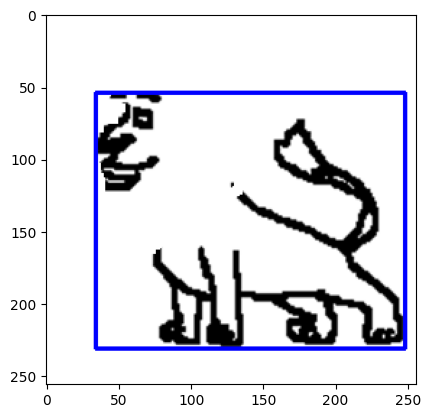

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# contour은 흰색의 물체를 검출.
IMG_DIR = '/home/evergrin/iu/datas/imgs/yahoo'
# img = cv2.imread(os.path.join(IMG_DIR, 'img0000.png'))
img = cv2.imread('/home/evergrin/iu/datas/imgs/data_set/lion_0187_000.png')
imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# imgray = np.invert(imgray)

print(imgray.shape)
ret,thresh = cv2.threshold(imgray,200,255,0)
thresh = cv2.bitwise_not(thresh)


contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sxs = []
sys = []
exs = []
eys = []

for i in range(len(contours)):
    x,y,w,h = cv2.boundingRect(contours[i])
    sxs.append(x)
    sys.append(y)
    exs.append(x+w)
    eys.append(y+h)

sxs = np.array(sxs)
sys = np.array(sys)
exs = np.array(exs)
eys = np.array(eys)

#     cv2.drawContours(img, [contours[i]], -1, (0, 0, 255), 2)
    # cv2.putText(img, str(i), tuple(contours[i][0][0]), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 0), 1)
    # print(i, hierarchy[0][i])

sx,sy,ex,ey = np.min(sxs), np.min(sys), np.max(exs), np.max(eys)
img = cv2.rectangle(img,(sx,sy),(ex,ey),(0, 0, 255), 2)

plt.imshow(img)

# # cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE) # cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # 

# print(hierarchy)

# cnt = contours[0]

# x,y,w,h = cv2.boundingRect(cnt)
# print(x, y, w, h)
# imgray = cv2.rectangle(imgray,(x,y),(x+w,y+h),(255,255,255),2)
# plt.imshow(thresh, cmap='gray')
# cv2.imshow('img', img)

# 디렉토리에 있는 gif file을 1/2 사이즈로 일괄 변경한다.

gif_list = glob.glob(os.path.join(IMG_LOAD_BASE_PATH, "*.gif"))

for gif_file in gif_list:

    vclip = VideoClip()
    vclip.load_gif(gif_file, grayscale=True)
    new_file = dir_path_change(gif_file, IMG_SAVE_BASE_PATH, "gif")
    vclip.make_gif(new_file, ratio=0.5)


In [ ]:
# 디렉토리에 있는 gif file을 1/2 사이즈로 일괄 변경한다.

gif_list = glob.glob(os.path.join(IMG_LOAD_BASE_PATH, "*.gif"))

for idx, gif_file in enumerate(gif_list):

    clip = VideoClip(gif_path=gif_file)
    
    imgfrm = ImgFrame(img=clip.clips[0], do_norm=False)
    
    # vclip.load_gif(gif_file, grayscale=True)
    file_name = os.path.join(IMG_SAVE_BASE_PATH, f"lion_{500+idx:04d}.png")
    imgfrm.to_image(save_file=file_name)
    # new_file = dir_path_change(gif_file, IMG_SAVE_BASE_PATH, "gif")
    # vclip.make_gif(new_file, ratio=0.5)
